In [1]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Directory where the dataset will be downloaded and extracted
DATA_DIR = 'datasets'
os.makedirs(DATA_DIR, exist_ok=True)

def download_dataset(dataset_name, url):
    """
    Downloads and extracts a zip file containing the dataset.
    """
    zip_path = os.path.join(DATA_DIR, f"{dataset_name}.zip")
    extract_path = os.path.join(DATA_DIR, dataset_name)

    # Download the dataset
    print(f"Downloading {dataset_name} from {url}...")
    urllib.request.urlretrieve(url, zip_path)

    # Extract the zip file
    print(f"Extracting {dataset_name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        file_names = zip_ref.namelist()
        print(f"Files in the zip: {file_names}")

    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"Dataset {dataset_name} extracted to {extract_path}.")
    return extract_path, file_names

def load_data(file_path, encoding='ISO-8859-1'):
    """
    Loads the dataset from a CSV file and returns a pandas DataFrame.
    """
    print(f"Loading data from {file_path}")
    df = pd.read_csv(file_path, encoding=encoding, on_bad_lines='skip')
    return df

def preprocess_data(df, batch_size=64, time_steps=30):
    """
    Preprocesses the data:
    - Drops Date and Time columns.
    - Uses all remaining features.
    - Normalizes the features.
    - Reshapes data into 3D tensors (samples, time_steps, features).
    - Splits into training, validation, and test sets.
    """
    print("Starting preprocessing...")

    # Drop Date and Time columns
    df = df.drop(columns=['Date', 'Time'])
    print("Dropped Date and Time columns.")

    # Use all remaining columns as features
    X = df.drop(columns=['Room_Occupancy_Count'])
    y = df['Room_Occupancy_Count']
    features = X.shape[1]  # Set features dynamically based on remaining columns
    print(f"Total features used: {features}")

    # Ensure total samples are compatible with reshaping
    total_samples = (len(X) // time_steps) * time_steps
    X, y = X.iloc[:total_samples], y.iloc[:total_samples]
    print(f"Adjusted dataset size: {X.shape}, Labels size: {y.shape}")

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    print("Features normalized.")

    # Reshape X into (samples, time_steps, features)
    X = X.reshape(-1, time_steps, features)
    y = y.values.reshape(-1, time_steps)[:, 0]  # Ensure y matches the number of sequences in X
    print(f"Reshaped X to: {X.shape}, Reshaped y to: {y.shape}")

    # Split into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print("Data split into training, validation, and test sets.")

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.int64)

    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)

    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)

    # Output dataset shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    print("Preprocessing complete.")
    return train_loader, valid_loader, test_loader, X_train, X_valid, X_test, y_train, y_valid, y_test

# Main function to run the entire process
if __name__ == "__main__":
    dataset_name = 'RoomOccupancy'
    dataset_url = 'https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip'

    # Download and extract the dataset
    extract_path, file_names = download_dataset(dataset_name, dataset_url)

    # Load the data
    main_file_path = os.path.join(extract_path, file_names[0])  # Assuming the first file is the main CSV
    df = load_data(main_file_path)

    # Preprocess the data
    train_loader, valid_loader, test_loader, X_train, X_valid, X_test, y_train, y_valid, y_test = preprocess_data(df)

    # Output the number of classes
    n_classes = len(torch.unique(y_train))
    print(f"Number of classes: {n_classes}")


Extracting RoomOccupancy...
Files in the zip: ['Occupancy_Estimation.csv']
Dataset RoomOccupancy extracted to datasets/RoomOccupancy.
Loading data from datasets/RoomOccupancy/Occupancy_Estimation.csv
Starting preprocessing...
Dropped Date and Time columns.
Total features used: 16
Adjusted dataset size: (10110, 16), Labels size: (10110,)
Features normalized.
Reshaped X to: (337, 30, 16), Reshaped y to: (337,)
Data split into training, validation, and test sets.
X_train shape: torch.Size([202, 30, 16]), y_train shape: torch.Size([202])
X_valid shape: torch.Size([67, 30, 16]), y_valid shape: torch.Size([67])
X_test shape: torch.Size([68, 30, 16]), y_test shape: torch.Size([68])
Preprocessing complete.
Number of classes: 4


In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from sklearn.metrics import accuracy_score

In [4]:
import math

class TimeSeriesPatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim, input_timesteps):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels

        # Calculate the number of patches, adjusting for padding if necessary
        # Ceiling division to account for padding
        self.num_patches = -(-input_timesteps // patch_size)
        self.padding = (
            self.num_patches * patch_size
        ) - input_timesteps  # Calculate padding length

        self.conv_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

        self.class_token_embeddings = nn.Parameter(
            torch.randn((1, 1, embedding_dim), requires_grad=True)
        )
        self.position_embeddings = PositionalEncoding(embedding_dim, dropout=0.1, max_len=input_timesteps)

    def forward(self, x):
        # Pad the input sequence if necessary
        if self.padding > 0:
            x = nn.functional.pad(x, (0, 0, 0, self.padding))  # Pad the second to last dimension, which is input_timesteps

        # We use a Conv1d layer to generate the patch embeddings
        x = x.permute(0, 2, 1)  # (batch, features, timesteps)
        conv_output = self.conv_layer(x)
        conv_output = conv_output.permute(0, 2, 1)  # (batch, timesteps, features)

        batch_size = x.shape[0]
        class_tokens = self.class_token_embeddings.expand(batch_size, -1, -1)
        output = torch.cat((class_tokens, conv_output), dim=1)

        output = self.position_embeddings(output)

        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

    def pos_encoding(self, q_len, d_model, normalize=True):
        pe = torch.zeros(q_len, d_model)
        position = torch.arange(0, q_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        if normalize:
            pe = pe - pe.mean()
            pe = pe / (pe.std() * 10)
        return pe

    def forward(self, x):
        x = x + self.pos_encoding(q_len = x.size(1), d_model = x.size(2))
        return self.dropout(x)

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


def get_pos_encoder(pos_encoding):
    if pos_encoding == 'fixed':
        return PositionalEncoding
    elif pos_encoding == 'learned':
        return LearnedPositionalEncoding
    else:
        raise ValueError(f"Unknown positional encoding type: {pos_encoding}")



In [5]:
random_instances, random_labels = next(iter(train_loader))
random_instance = random_instances[0]

BATCH_SIZE = random_instances.shape[0]
TIMESTEPS = random_instance.shape[0]
CHANNELS = random_instance.shape[1]
PATCH_SIZE = 8

patch_embedding_layer = TimeSeriesPatchEmbeddingLayer(
    in_channels=CHANNELS,
    patch_size=PATCH_SIZE,
    embedding_dim=CHANNELS * PATCH_SIZE,
    input_timesteps=TIMESTEPS,
)

patch_embeddings = patch_embedding_layer(random_instances)
patch_embeddings.shape

summary(
    model=patch_embedding_layer,
    # (batch_size, input_channels, input_timesteps)
    input_size=(BATCH_SIZE, TIMESTEPS, CHANNELS),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
TimeSeriesPatchEmbeddingLayer (TimeSeriesPatchEmbeddingLayer)     [64, 30, 16]         [64, 5, 128]         128                  True
├─Conv1d (conv_layer)                                             [64, 16, 32]         [64, 128, 4]         16,512               True
├─PositionalEncoding (position_embeddings)                        [64, 5, 128]         [64, 5, 128]         --                   --
│    └─Dropout (dropout)                                          [64, 5, 128]         [64, 5, 128]         --                   --
Total params: 16,640
Trainable params: 16,640
Non-trainable params: 0
Total mult-adds (M): 4.23
Input size (MB): 0.12
Forward/backward pass size (MB): 0.26
Params size (MB): 0.07
Estimated Total Size (MB): 0.45

In [6]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_transformer_layers=6, num_heads=8, dim_feedforward=128, dropout=0.1, num_classes=2):
        super().__init__()

        # Embedding layer
        self.patch_embedding = TimeSeriesPatchEmbeddingLayer(in_channels, patch_size, embedding_dim, input_timesteps)

        # Calculate the number of patches
        self.num_patches = -(-input_timesteps // patch_size)

        # Transformer Encoder
        # Setting batch_first=True to accommodate inputs with batch dimension first
        encoder_layers = TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_transformer_layers)

        # Feedforward layer
        self.ff_layer = nn.Linear(embedding_dim, dim_feedforward)
        # Classifier Head
        self.classifier = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # x shape: (batch_size, in_channels, input_timesteps)

        # Get patch embeddings
        x = self.patch_embedding(x)  # Output shape: (batch_size, num_patches + 1, embedding_dim)

        # Apply Transformer Encoder with batch first
        x = self.transformer_encoder(x)  # Output shape: (batch_size, num_patches + 1, embedding_dim)

        # Use the output corresponding to the class token for classification
        class_token_output = x[:, 0, :]  # Select the class token for each item in the batch

        # Feedforward layer
        x = self.ff_layer(class_token_output)

        # Classifier head
        output = self.classifier(x)  # Output shape: (batch_size, num_classes)

        return output


In [7]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=32,
    num_transformer_layers=4,
    num_heads=4,
    dim_feedforward=128,
    dropout=0.2,
    num_classes=n_classes,
).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler to reduce the learning rate by the specified step size and factor (gamma) every step_size epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

summary(
    model=model,
    input_size=(BATCH_SIZE, TIMESTEPS, CHANNELS),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TimeSeriesTransformer (TimeSeriesTransformer)           [64, 30, 16]         [64, 4]              --                   True
├─TimeSeriesPatchEmbeddingLayer (patch_embedding)       [64, 30, 16]         [64, 5, 32]          32                   True
│    └─Conv1d (conv_layer)                              [64, 16, 32]         [64, 32, 4]          4,128                True
│    └─PositionalEncoding (position_embeddings)         [64, 5, 32]          [64, 5, 32]          --                   --
│    │    └─Dropout (dropout)                           [64, 5, 32]          [64, 5, 32]          --                   --
├─TransformerEncoder (transformer_encoder)              [64, 5, 32]          [64, 5, 32]          --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

In [8]:
# Model, loss function, and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Number of epochs
n_epochs = 20

# Initialize variables for tracking the best model
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    train_losses = []
    train_correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients

        predictions = model(inputs)  # Forward pass
        loss = criterion(predictions, labels)  # Calculate loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_losses.append(loss.item())

        # Count the number of correct predictions
        train_correct += (predictions.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = np.mean(train_losses)
    train_acc = train_correct / total

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        validation_losses = []
        validation_correct = 0
        total_val = 0

        for inputs, labels in valid_loader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            validation_losses.append(loss.item())

            validation_correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

        validation_loss = np.mean(validation_losses)
        validation_acc = validation_correct / total_val

    # Check if this is the best model so far
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        # Save the model
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {validation_acc:.4f}')

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {validation_loss:.4f}, Val Acc: {validation_acc:.4f}')

# Loading the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')

Epoch 1: New best model saved with validation accuracy: 0.8438
Epoch 1, Train Loss: 1.2626, Train Acc: 0.4896, Val Loss: 0.7342, Val Acc: 0.8438
Epoch 2, Train Loss: 0.6194, Train Acc: 0.8698, Val Loss: 0.5179, Val Acc: 0.8438
Epoch 3: New best model saved with validation accuracy: 0.8594
Epoch 3, Train Loss: 0.4048, Train Acc: 0.8594, Val Loss: 0.4058, Val Acc: 0.8594
Epoch 4, Train Loss: 0.2947, Train Acc: 0.9010, Val Loss: 0.3281, Val Acc: 0.8594
Epoch 5, Train Loss: 0.2437, Train Acc: 0.9062, Val Loss: 0.2960, Val Acc: 0.8438
Epoch 6, Train Loss: 0.2005, Train Acc: 0.9010, Val Loss: 0.2713, Val Acc: 0.8438
Epoch 7, Train Loss: 0.1747, Train Acc: 0.9427, Val Loss: 0.2548, Val Acc: 0.8438
Epoch 8: New best model saved with validation accuracy: 0.8750
Epoch 8, Train Loss: 0.1598, Train Acc: 0.9375, Val Loss: 0.2413, Val Acc: 0.8750
Epoch 9: New best model saved with validation accuracy: 0.8906
Epoch 9, Train Loss: 0.1536, Train Acc: 0.9167, Val Loss: 0.2240, Val Acc: 0.8906
Epoch 10: 

<ipython-input-8-9c1bc2205eaa>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [9]:
# Prediction
model.eval()
with torch.no_grad():
    Y_pred_prob = model(X_test)

Y_pred = Y_pred_prob.argmax(1)

print(classification_report(y_test, Y_pred))
confusion = confusion_matrix(y_test, Y_pred)
print(f"Confusion matrix:\n{confusion}")

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        51
           1       0.75      1.00      0.86         3
           2       0.57      0.57      0.57         7
           3       0.57      0.57      0.57         7

    accuracy                           0.90        68
   macro avg       0.72      0.78      0.75        68
weighted avg       0.90      0.90      0.90        68

Confusion matrix:
[[50  1  0  0]
 [ 0  3  0  0]
 [ 0  0  4  3]
 [ 0  0  3  4]]


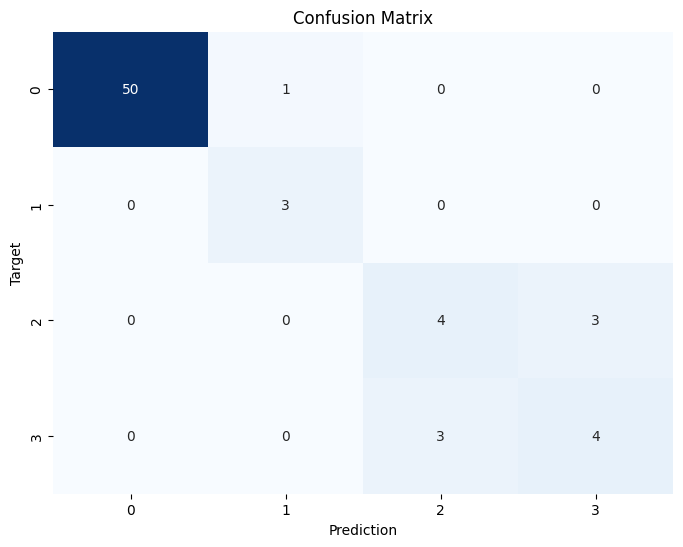

In [10]:
# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.title("Confusion Matrix")
plt.show()

## Positional Encodings

In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange
import pandas as pd

class Attention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        attn = torch.matmul(q, k) * self.scale
        attn = nn.functional.softmax(attn, dim=-1)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out


class Attention_Rel_Scl(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.relative_bias_table = nn.Parameter(torch.zeros((2 * self.seq_len - 1), num_heads))
        coords = torch.meshgrid((torch.arange(1), torch.arange(self.seq_len)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[1] += self.seq_len - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        attn = torch.matmul(q, k) * self.scale
        attn = nn.functional.softmax(attn, dim=-1)

        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, 8))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=1 * self.seq_len, w=1 * self.seq_len)
        attn = attn + relative_bias

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out


class Attention_Rel_Vec(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.Er = nn.Parameter(torch.randn(self.seq_len, int(emb_size / num_heads)))

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(self.seq_len, self.seq_len))
                .unsqueeze(0).unsqueeze(0)
        )

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        QEr = torch.matmul(q, self.Er.transpose(0, 1))
        Srel = self.skew(QEr)

        attn = torch.matmul(q, k)
        attn = (attn + Srel) * self.scale

        attn = nn.functional.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out

    def skew(self, QEr):
        padded = nn.functional.pad(QEr, (1, 0))
        batch_size, num_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
        Srel = reshaped[:, :, 1:, :]
        return Srel


In [ ]:
class TUPEConfig:
    num_layers: int = 6
    num_heads: int = 8
    d_model: int = 128
    d_head: int = 0
    max_len: int = 256
    dropout: float = 0.1
    expansion_factor: int = 1
    relative_bias: bool = True
    bidirectional_bias: bool = True
    num_buckets: int = 32
    max_distance: int = 128

    def __post_init__(self):
        d_head, remainder = divmod(self.d_model, self.num_heads)
        assert remainder == 0, "`d_model` should be divisible by `num_heads`"
        self.d_head = d_head

In [ ]:
def _get_relative_position_bucket(
    relative_position, bidirectional, num_buckets, max_distance
):
    """
    from https://github.com/huggingface/transformers/blob/master/src/transformers/models/t5/modeling_t5.py
    """
    relative_buckets = 0
    if bidirectional:
        num_buckets //= 2
        relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
        relative_position = torch.abs(relative_position)
    else:
        relative_position = -torch.min(
            relative_position, torch.zeros_like(relative_position)
        )
    # now relative_position is in the range [0, inf)

    # half of the buckets are for exact increments in positions
    max_exact = num_buckets // 2
    is_small = relative_position < max_exact

    # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
    relative_postion_if_large = max_exact + (
        torch.log(relative_position.float() / max_exact)
        / math.log(max_distance / max_exact)
        * (num_buckets - max_exact)
    ).to(torch.long)
    relative_postion_if_large = torch.min(
        relative_postion_if_large,
        torch.full_like(relative_postion_if_large, num_buckets - 1),
    )

    relative_buckets += torch.where(
        is_small, relative_position, relative_postion_if_large
    )
    return relative_buckets


def get_relative_positions(
    seq_len, bidirectional=True, num_buckets=32, max_distance=128
):
    x = torch.arange(seq_len)[None, :]
    y = torch.arange(seq_len)[:, None]
    relative_positions = _get_relative_position_bucket(
        x - y, bidirectional, num_buckets, max_distance
    )
    return relative_positions

In [ ]:
class TUPEMultiHeadAttention(nn.Module):
    def __init__(self, config: TUPEConfig, pos_embed: nn.Module) -> None:
        super().__init__()
        self.max_len = config.max_len
        self.num_heads = config.num_heads
        self.num_buckets = config.num_buckets
        self.max_distance = config.max_distance
        self.bidirectional = config.bidirectional_bias
        self.scale = math.sqrt(2 * config.d_head)

        self.pos_embed = pos_embed
        self.dropout = nn.Dropout(config.dropout)

        # kqv in one pass
        self.pos_kq = nn.Linear(config.d_model, 2 * config.d_model, bias=False)
        self.tok_kqv = nn.Linear(config.d_model, 3 * config.d_model, bias=False)

        self.relative_bias = config.relative_bias
        if config.relative_bias:
            self.bias = nn.Embedding(config.max_len * 2, config.num_heads)

    def forward(self, x: torch.tensor) -> torch.tensor:
        batch_size, seq_len, _ = x.shape

        pos_embed = self.pos_embed(seq_len).repeat(batch_size, 1, 1)
        # pos_embed.shape == (batch_size, seq_len, d_model)
        pos_key, pos_query = self.pos_kq(pos_embed).chunk(2, dim=-1)
        pos_key = pos_key.view(batch_size, seq_len, self.num_heads, -1).permute(
            0, 2, 3, 1
        )
        # pos_key.shape == (batch_size, num_heads, d_head, seq_len)
        pos_query = pos_query.view(batch_size, seq_len, self.num_heads, -1).transpose(
            1, 2
        )
        # pos_query.shape == (batch_size, num_heads, seq_len, d_head)
        pos_attn = torch.matmul(pos_query, pos_key)
        # pos_attn.shape == (batch_size, num_heads, seq_len, seq_len)

        tok_key, tok_query, tok_value = self.tok_kqv(x).chunk(3, dim=-1)
        tok_key = tok_key.view(batch_size, seq_len, self.num_heads, -1).permute(
            0, 2, 3, 1
        )
        # tok_key.shape == (batch_size, num_heads, d_head, seq_len)
        tok_query = tok_query.view(batch_size, seq_len, self.num_heads, -1).transpose(
            1, 2
        )
        tok_value = tok_value.view(batch_size, seq_len, self.num_heads, -1).transpose(
            1, 2
        )
        # tok_qv.shape == (batch_size, num_heads, seq_len, d_head)
        tok_attn = torch.matmul(tok_query, tok_key)
        # tok_attn.shape == (batch_size, num_heads, seq_len, seq_len)

        attn = (tok_attn + pos_attn) / self.scale
        if self.relative_bias:
            relative_positions = get_relative_positions(
                seq_len, self.bidirectional, self.num_buckets, self.max_distance
            ).to(attn.device)
            # relative_positions.shape == (seq_len, seq_len)
            bias = self.bias(relative_positions + self.max_len)
            # bias.shape == (seq_len, seq_len, num_heads)
            bias = bias.permute(2, 0, 1).unsqueeze(0)
            # bias.shape == (1, num_heads, seq_len, seq_len)
            attn = attn + bias

        attn = F.softmax(attn, dim=-1)
        # attn.shape == (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attn, tok_value)
        # out.shape == (batch_size, num_heads, seq_len, d_head)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)
        # out.shape == (batch_size, seq_len, d_model)
        out = self.dropout(out)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math
from torchsummary import summary

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

    def pos_encoding(self, q_len, d_model, normalize=True):
        pe = torch.zeros(q_len, d_model)
        position = torch.arange(0, q_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        if normalize:
            pe = pe - pe.mean()
            pe = pe / (pe.std() * 10)
        return pe

    def forward(self, x):
        x = x + self.pos_encoding(q_len=x.size(1), d_model=x.size(2))
        return self.dropout(x)

# Learned Positional Encoding
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Time Series Patch Embedding Layer
class TimeSeriesPatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim, input_timesteps, pos_encoding='fixed'):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels

        self.num_patches = -(-input_timesteps // patch_size)
        self.padding = (self.num_patches * patch_size) - input_timesteps

        self.conv_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

        self.class_token_embeddings = nn.Parameter(
            torch.randn((1, 1, embedding_dim), requires_grad=True)
        )

        # Instantiate the positional encoding
        pos_encoder_class = get_pos_encoder(pos_encoding)
        self.position_embeddings = pos_encoder_class(embedding_dim, dropout=0.1, max_len=input_timesteps)

    def forward(self, x):
        if self.padding > 0:
            x = nn.functional.pad(x, (0, 0, 0, self.padding))

        x = x.permute(0, 2, 1)
        conv_output = self.conv_layer(x)
        conv_output = conv_output.permute(0, 2, 1)

        batch_size = x.shape[0]
        class_tokens = self.class_token_embeddings.expand(batch_size, -1, -1)
        output = torch.cat((class_tokens, conv_output), dim=1)

        output = self.position_embeddings(output)

        return output

# Get Positional Encoding
def get_pos_encoder(pos_encoding):
    if pos_encoding == 'fixed':
        return PositionalEncoding
    elif pos_encoding == 'learned':
        return LearnedPositionalEncoding
    else:
        raise ValueError(f"Unknown positional encoding type: {pos_encoding}")

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, pos_encoding='fixed', num_transformer_layers=6, num_heads=8, dim_feedforward=128, dropout=0.1, num_classes=2, attention_type='absolute'):
        super().__init__()

        self.patch_embedding = TimeSeriesPatchEmbeddingLayer(in_channels, patch_size, embedding_dim, input_timesteps, pos_encoding)
        self.num_patches = -(-input_timesteps // patch_size)

        if attention_type == 'relative_scl':
            self.attention_layer = Attention_Rel_Scl(embedding_dim, num_heads, self.num_patches + 1, dropout)
        elif attention_type == 'relative_vec':
            self.attention_layer = Attention_Rel_Vec(embedding_dim, num_heads, self.num_patches + 1, dropout)
        elif attention_type == 'tupe':
            self.attention_layer = TUPEMultiHeadAttention(tupe_config, pos_embed)
        else:
            self.attention_layer = Attention(embedding_dim, num_heads, dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_transformer_layers)

        self.ff_layer = nn.Linear(embedding_dim, dim_feedforward)
        self.classifier = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.attention_layer(x)
        x = self.transformer_encoder(x)
        class_token_output = x[:, 0, :]
        x = self.ff_layer(class_token_output)
        output = self.classifier(x)
        return output


random_instances, random_labels = next(iter(train_loader))
random_instance = random_instances[0]

BATCH_SIZE = random_instances.shape[0]
TIMESTEPS = random_instance.shape[0]
CHANNELS = random_instance.shape[1]
PATCH_SIZE = 8

patch_embedding_layer = TimeSeriesPatchEmbeddingLayer(
    in_channels=CHANNELS,
    patch_size=PATCH_SIZE,
    embedding_dim=CHANNELS * PATCH_SIZE,
    input_timesteps=TIMESTEPS,
)

patch_embeddings = patch_embedding_layer(random_instances)
patch_embeddings.shape

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=32,
    pos_encoding='fixed',
    num_transformer_layers=4,
    num_heads=4,
    dim_feedforward=128,
    dropout=0.2,
    num_classes=n_classes,
).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)


# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_correct += (predictions.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = np.mean(train_losses)
        train_acc = train_correct / total

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

# Evaluation Function
def evaluate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss = total_loss / len(valid_loader)
    val_acc = correct / total_val
    return val_loss, val_acc

# Train the model
n_epochs = 10
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    train_model(model, train_loader, loss_fn, optimizer, num_epochs=1)
    val_loss, val_acc = evaluate_model(model, valid_loader, loss_fn)

    if val_acc > best_validation_acc:
        best_validation_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {val_acc:.4f}')

    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    lr_scheduler.step()

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')



Epoch 1, Train Loss: 1.4569, Train Acc: 0.2266
Epoch 1: New best model saved with validation accuracy: 0.2656
Epoch 1, Val Loss: 1.3812, Val Acc: 0.2656
Epoch 1, Train Loss: 1.3724, Train Acc: 0.3125
Epoch 2: New best model saved with validation accuracy: 0.3750
Epoch 2, Val Loss: 1.3303, Val Acc: 0.3750
Epoch 1, Train Loss: 1.3081, Train Acc: 0.3750
Epoch 3: New best model saved with validation accuracy: 0.4688
Epoch 3, Val Loss: 1.2838, Val Acc: 0.4688
Epoch 1, Train Loss: 1.2549, Train Acc: 0.4766
Epoch 4, Val Loss: 1.2554, Val Acc: 0.4531
Epoch 1, Train Loss: 1.1858, Train Acc: 0.4922
Epoch 5: New best model saved with validation accuracy: 0.5000
Epoch 5, Val Loss: 1.2337, Val Acc: 0.5000
Epoch 1, Train Loss: 1.1196, Train Acc: 0.5703
Epoch 6, Val Loss: 1.1852, Val Acc: 0.4844
Epoch 1, Train Loss: 1.0403, Train Acc: 0.6250
Epoch 7, Val Loss: 1.1052, Val Acc: 0.4844
Epoch 1, Train Loss: 1.0115, Train Acc: 0.5703
Epoch 8: New best model saved with validation accuracy: 0.5156
Epoch 8,

<ipython-input-16-b06036bd6b7c>:230: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:
import torch
import torch.nn as nn
from einops import rearrange
import pandas as pd

class Attention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        attn = torch.matmul(q, k) * self.scale
        attn = nn.functional.softmax(attn, dim=-1)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out


class Attention_Rel_Scl(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.relative_bias_table = nn.Parameter(torch.zeros((2 * self.seq_len - 1), num_heads))
        coords = torch.meshgrid((torch.arange(1), torch.arange(self.seq_len)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[1] += self.seq_len - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        attn = torch.matmul(q, k) * self.scale
        attn = nn.functional.softmax(attn, dim=-1)

        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, 8))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=1 * self.seq_len, w=1 * self.seq_len)
        attn = attn + relative_bias

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out


class Attention_Rel_Vec(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.Er = nn.Parameter(torch.randn(self.seq_len, int(emb_size / num_heads)))

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(self.seq_len, self.seq_len))
                .unsqueeze(0).unsqueeze(0)
        )

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        QEr = torch.matmul(q, self.Er.transpose(0, 1))
        Srel = self.skew(QEr)

        attn = torch.matmul(q, k)
        attn = (attn + Srel) * self.scale

        attn = nn.functional.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2)
        out = out.reshape(batch_size, seq_len, -1)
        out = self.to_out(out)
        return out

    def skew(self, QEr):
        padded = nn.functional.pad(QEr, (1, 0))
        batch_size, num_heads, num_rows, num_cols = padded.shape
        reshaped = padded.reshape(batch_size, num_heads, num_cols, num_rows)
        Srel = reshaped[:, :, 1:, :]
        return Srel


In [ ]:
class tAPE(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(tAPE, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin((position * div_term) * (d_model / max_len))
        pe[:, 1::2] = torch.cos((position * div_term) * (d_model / max_len))
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class AbsolutePositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(AbsolutePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1024):
        super(LearnablePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = nn.Parameter(torch.empty(max_len, d_model))
        nn.init.uniform_(self.pe, -0.02, 0.02)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)

In [ ]:
def get_pos_encoder(pos_encoding):
    if pos_encoding == 'fixed':
        return PositionalEncoding
    elif pos_encoding == 'learned':
        return LearnedPositionalEncoding
    elif pos_encoding == 'tAPE':
        return tAPE
    elif pos_encoding == 'absolute':
        return AbsolutePositionalEncoding
    else:
        raise ValueError(f"Unknown positional encoding type: {pos_encoding}")


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=32,
    pos_encoding='tAPE',
    num_transformer_layers=4,
    num_heads=4,
    dim_feedforward=128,
    dropout=0.2,
    num_classes=n_classes,
).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)


# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_correct += (predictions.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = np.mean(train_losses)
        train_acc = train_correct / total

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

# Evaluation Function
def evaluate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss = total_loss / len(valid_loader)
    val_acc = correct / total_val
    return val_loss, val_acc

# Train the model
n_epochs = 20
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    train_model(model, train_loader, loss_fn, optimizer, num_epochs=1)
    val_loss, val_acc = evaluate_model(model, valid_loader, loss_fn)

    if val_acc > best_validation_acc:
        best_validation_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {val_acc:.4f}')

    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    lr_scheduler.step()

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')

Epoch 1, Train Loss: 1.4311, Train Acc: 0.2266
Epoch 1: New best model saved with validation accuracy: 0.3281
Epoch 1, Val Loss: 1.3790, Val Acc: 0.3281
Epoch 1, Train Loss: 1.3741, Train Acc: 0.2891
Epoch 2: New best model saved with validation accuracy: 0.3438
Epoch 2, Val Loss: 1.3855, Val Acc: 0.3438
Epoch 1, Train Loss: 1.3881, Train Acc: 0.2812
Epoch 3, Val Loss: 1.3670, Val Acc: 0.3281
Epoch 1, Train Loss: 1.3506, Train Acc: 0.2969
Epoch 4, Val Loss: 1.3426, Val Acc: 0.2969
Epoch 1, Train Loss: 1.3434, Train Acc: 0.3125
Epoch 5: New best model saved with validation accuracy: 0.5312
Epoch 5, Val Loss: 1.3242, Val Acc: 0.5312
Epoch 1, Train Loss: 1.2763, Train Acc: 0.4688
Epoch 6, Val Loss: 1.3288, Val Acc: 0.3125
Epoch 1, Train Loss: 1.2578, Train Acc: 0.3984
Epoch 7, Val Loss: 1.2999, Val Acc: 0.3438
Epoch 1, Train Loss: 1.2230, Train Acc: 0.4219
Epoch 8, Val Loss: 1.2241, Val Acc: 0.4375
Epoch 1, Train Loss: 1.1781, Train Acc: 0.5078
Epoch 9: New best model saved with validatio

<ipython-input-20-f4ea5e1fc41b>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=32,
    pos_encoding='fixed',
    num_transformer_layers=4,
    num_heads=4,
    dim_feedforward=128,
    dropout=0.2,
    num_classes=n_classes,
    attention_type= 'relative_vec',
).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)


# Training Function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        train_correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_correct += (predictions.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = np.mean(train_losses)
        train_acc = train_correct / total

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

# Evaluation Function
def evaluate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            correct += (predictions.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    val_loss = total_loss / len(valid_loader)
    val_acc = correct / total_val
    return val_loss, val_acc

# Train the model
n_epochs = 20
best_validation_acc = 0.0
best_model_path = 'best_model_v2.pth'

for epoch in range(n_epochs):
    train_model(model, train_loader, loss_fn, optimizer, num_epochs=1)
    val_loss, val_acc = evaluate_model(model, valid_loader, loss_fn)

    if val_acc > best_validation_acc:
        best_validation_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch {epoch+1}: New best model saved with validation accuracy: {val_acc:.4f}')

    print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    lr_scheduler.step()

# Load the best model
model.load_state_dict(torch.load(best_model_path))
print('Loaded best model for testing or further use.')

Epoch 1, Train Loss: 1.4358, Train Acc: 0.2422
Epoch 1: New best model saved with validation accuracy: 0.4062
Epoch 1, Val Loss: 1.3170, Val Acc: 0.4062
Epoch 1, Train Loss: 1.3419, Train Acc: 0.3359
Epoch 2: New best model saved with validation accuracy: 0.4844
Epoch 2, Val Loss: 1.2702, Val Acc: 0.4844
Epoch 1, Train Loss: 1.2761, Train Acc: 0.3984
Epoch 3, Val Loss: 1.1982, Val Acc: 0.4688
Epoch 1, Train Loss: 1.2040, Train Acc: 0.4609
Epoch 4: New best model saved with validation accuracy: 0.5625
Epoch 4, Val Loss: 1.1222, Val Acc: 0.5625
Epoch 1, Train Loss: 1.1163, Train Acc: 0.5156
Epoch 5: New best model saved with validation accuracy: 0.6406
Epoch 5, Val Loss: 1.0442, Val Acc: 0.6406
Epoch 1, Train Loss: 1.0287, Train Acc: 0.5391
Epoch 6, Val Loss: 0.9654, Val Acc: 0.5781
Epoch 1, Train Loss: 0.9441, Train Acc: 0.5938
Epoch 7, Val Loss: 0.9070, Val Acc: 0.5781
Epoch 1, Train Loss: 0.9253, Train Acc: 0.6328
Epoch 8, Val Loss: 0.8725, Val Acc: 0.6094
Epoch 1, Train Loss: 0.8254,

<ipython-input-21-014626430eba>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


### TUPE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TUPEConfig:
    def __init__(self):
        self.d_model = 128
        self.num_heads = 8
        self.dim_feedforward = 512
        self.dropout = 0.1
        self.max_len = 5000
        self.num_buckets = 32
        self.max_distance = 128
        self.relative_bias = True
        self.bidirectional_bias = True

class TUPEMultiHeadAttention(nn.Module):
    def __init__(self, config: TUPEConfig, pos_embed: nn.Module) -> None:
        super().__init__()
        self.max_len = config.max_len
        self.num_heads = config.num_heads
        self.num_buckets = config.num_buckets
        self.max_distance = config.max_distance
        self.bidirectional = config.bidirectional_bias
        self.scale = math.sqrt(2 * config.d_model // config.num_heads)

        self.pos_embed = pos_embed
        self.dropout = nn.Dropout(config.dropout)

        # kqv in one pass
        self.pos_kq = nn.Linear(config.d_model, 2 * config.d_model, bias=False)
        self.tok_kqv = nn.Linear(config.d_model, 3 * config.d_model, bias=False)

        self.relative_bias = config.relative_bias
        if config.relative_bias:
            self.bias = nn.Embedding(config.max_len * 2, config.num_heads)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape

        pos_embed = self.pos_embed(seq_len).repeat(batch_size, 1, 1)
        # pos_embed.shape == (batch_size, seq_len, d_model)
        pos_key, pos_query = self.pos_kq(pos_embed).chunk(2, dim=-1)
        pos_key = pos_key.view(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        # pos_key.shape == (batch_size, num_heads, d_head, seq_len)
        pos_query = pos_query.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        # pos_query.shape == (batch_size, num_heads, seq_len, d_head)
        pos_attn = torch.matmul(pos_query, pos_key)
        # pos_attn.shape == (batch_size, num_heads, seq_len, seq_len)

        tok_key, tok_query, tok_value = self.tok_kqv(x).chunk(3, dim=-1)
        tok_key = tok_key.view(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        # tok_key.shape == (batch_size, num_heads, d_head, seq_len)
        tok_query = tok_query.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        tok_value = tok_value.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        # tok_qv.shape == (batch_size, num_heads, seq_len, d_head)
        tok_attn = torch.matmul(tok_query, tok_key)
        # tok_attn.shape == (batch_size, num_heads, seq_len, seq_len)

        attn = (tok_attn + pos_attn) / self.scale
        if self.relative_bias:
            relative_positions = self.get_relative_positions(seq_len)
            # relative_positions.shape == (seq_len, seq_len)
            bias = self.bias(relative_positions + self.max_len)
            # bias.shape == (seq_len, seq_len, num_heads)
            bias = bias.permute(2, 0, 1).unsqueeze(0)
            # bias.shape == (1, num_heads, seq_len, seq_len)
            attn = attn + bias

        attn = F.softmax(attn, dim=-1)
        # attn.shape == (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attn, tok_value)
        # out.shape == (batch_size, num_heads, seq_len, d_head)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)
        # out.shape == (batch_size, seq_len, d_model)
        out = self.dropout(out)
        return out

    def get_relative_positions(self, seq_len):
        # Generate relative position encodings
        range_vec = torch.arange(seq_len)
        distance_mat = range_vec.unsqueeze(1) - range_vec.unsqueeze(0)
        distance_mat_clipped = torch.clamp(distance_mat, -self.max_distance, self.max_distance)
        final_mat = distance_mat_clipped + self.max_distance
        return final_mat


In [ ]:
class FixedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(FixedPositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, seq_len):
        return self.encoding[:, :seq_len, :].detach()

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_layers, num_heads, dim_feedforward, dropout, num_classes, attention_type, pos_encoding):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.attention_type = attention_type

        # Patch embedding
        self.patch_embedding = nn.Conv1d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_encoding = pos_encoding

        # Transformer layers with TUPEMultiHeadAttention
        self.transformer_layers = nn.ModuleList([
            TUPEMultiHeadAttention(
                config=TUPEConfig(),
                pos_embed=FixedPositionalEncoding(embedding_dim, max_len=input_timesteps)
            )
            for _ in range(num_layers)
        ])

        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        #print(f"Input to model: {x.shape}")

        # Patch embedding
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, seq_len, in_channels) to (batch_size, in_channels, seq_len)
        #print(f"Input to Conv1d: {x.shape}")

        x = self.patch_embedding(x)  # Apply Conv1d
        #print(f"Patch embedding output: {x.shape}")

        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, embedding_dim)
        #print(f"Patch embedding output permuted: {x.shape}")

        # Positional encoding
        seq_len = x.size(1)
        x = x + self.pos_encoding(seq_len).to(x.device)
        #print(f"Positional encoding output: {x.shape}")

        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)
            #print(f"Transformer layer output: {x.shape}")

        # Classification head
        x = x.mean(dim=1)
        x = self.classifier(x)
        #print(f"Classifier output: {x.shape}")
        return x

# Hyperparameters
TIMESTEPS = 30
CHANNELS = 6
n_classes = 44

# Initialize positional encoding
pos_embed = FixedPositionalEncoding(d_model=128, max_len=TIMESTEPS)

# Define the model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=8,
    embedding_dim=128,
    num_layers=4,
    num_heads=8,
    dim_feedforward=512,
    dropout=0.1,
    num_classes=n_classes,
    attention_type='tupe',
    pos_encoding=pos_embed,
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 20
best_valid_acc = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_preds = []
    valid_labels = []
    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_acc = accuracy_score(valid_labels, valid_preds)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

    # Save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_valid_acc:.4f}')


Epoch 1/20, Train Loss: 3.1447, Train Acc: 0.1406, Valid Loss: 2.9109, Valid Acc: 0.3594
Epoch 2/20, Train Loss: 2.8448, Train Acc: 0.3438, Valid Loss: 2.4550, Valid Acc: 0.3750
Epoch 3/20, Train Loss: 2.3032, Train Acc: 0.3281, Valid Loss: 1.7242, Valid Acc: 0.2969
Epoch 4/20, Train Loss: 1.5748, Train Acc: 0.3359, Valid Loss: 1.2022, Valid Acc: 0.4219
Epoch 5/20, Train Loss: 1.2348, Train Acc: 0.2969, Valid Loss: 1.0896, Valid Acc: 0.4375
Epoch 6/20, Train Loss: 1.1160, Train Acc: 0.3750, Valid Loss: 1.1139, Valid Acc: 0.2344
Epoch 7/20, Train Loss: 1.1004, Train Acc: 0.3594, Valid Loss: 1.0432, Valid Acc: 0.5781
Epoch 8/20, Train Loss: 1.0629, Train Acc: 0.4531, Valid Loss: 0.9556, Valid Acc: 0.5625
Epoch 9/20, Train Loss: 0.9763, Train Acc: 0.4922, Valid Loss: 0.9714, Valid Acc: 0.4062
Epoch 10/20, Train Loss: 0.9298, Train Acc: 0.4766, Valid Loss: 0.8266, Valid Acc: 0.5312
Epoch 11/20, Train Loss: 0.7606, Train Acc: 0.6016, Valid Loss: 0.7787, Valid Acc: 0.6094
Epoch 12/20, Train 

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_layers, num_heads, dim_feedforward, dropout, num_classes, pos_encoding_type, spe_params):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Patch embedding
        self.patch_embedding = nn.Conv1d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

        # Positional encoding
        if pos_encoding_type == 'sine':
            self.pos_encoding = SineSPE(num_heads=num_heads, in_features=embedding_dim // num_heads, **spe_params)
        elif pos_encoding_type == 'conv':
            self.pos_encoding = ConvSPE(ndim=1, num_heads=num_heads, in_features=embedding_dim // num_heads, **spe_params)
        else:
            raise ValueError("Invalid positional encoding type")

        # Transformer layers with TUPEMultiHeadAttention
        self.transformer_layers = nn.ModuleList([
            TUPEMultiHeadAttention(
                config=TUPEConfig(),
                pos_embed=self.pos_encoding
            )
            for _ in range(num_layers)
        ])

        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, seq_len, in_channels) to (batch_size, in_channels, seq_len)
        x = self.patch_embedding(x)  # Apply Conv1d
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, embedding_dim)

        # Positional encoding
        seq_len = x.size(1)
        pos_enc = self.pos_encoding(seq_len).to(x.device)
        x = x + pos_enc

        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)

        # Classification head
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x


In [ ]:
class SineSPE(nn.Module):
    def __init__(self, num_heads, in_features, max_len=512):
        super(SineSPE, self).__init__()
        self.num_heads = num_heads
        self.in_features = in_features
        self.max_len = max_len
        self.position = nn.Parameter(torch.zeros(1, max_len, in_features))
        self.register_buffer('sine', self._generate_sine_encoding())

    def _generate_sine_encoding(self):
        position = torch.arange(self.max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, self.in_features, 2).float() * -(math.log(10000.0) / self.in_features))
        encoding = torch.zeros(self.max_len, self.in_features)
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        return encoding

    def forward(self, seq_len):
        return self.sine[:seq_len, :].unsqueeze(0).repeat(self.num_heads, 1, 1)

class ConvSPE(nn.Module):
    def __init__(self, ndim, num_heads, in_features, kernel_size=7, padding=3):
        super(ConvSPE, self).__init__()
        self.conv = nn.Conv1d(in_features, in_features, kernel_size=kernel_size, padding=padding)
        self.num_heads = num_heads

    def forward(self, seq_len):
        # Generate sinusoidal encoding
        x = torch.arange(seq_len).unsqueeze(0).float()
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.squeeze(0).permute(1, 0).unsqueeze(0).repeat(self.num_heads, 1, 1)
        return x


In [ ]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

# Example of positional encoding classes
class SineSPE(nn.Module):
    def __init__(self, in_features, max_len=512):
        super(SineSPE, self).__init__()
        self.in_features = in_features
        self.max_len = max_len
        self.position = nn.Parameter(torch.zeros(1, max_len, in_features))
        self.register_buffer('sine', self._generate_sine_encoding())

    def _generate_sine_encoding(self):
        position = torch.arange(self.max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, self.in_features, 2).float() * -(math.log(10000.0) / self.in_features))
        encoding = torch.zeros(self.max_len, self.in_features)
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        return encoding

    def forward(self, seq_len):
        return self.sine[:seq_len, :].unsqueeze(0)  # Shape: (1, seq_len, in_features)


class ConvSPE(nn.Module):
    def __init__(self, num_heads, in_features, kernel_size=3, num_realizations=1):
        super(ConvSPE, self).__init__()
        padding = kernel_size // 2  # This ensures that the output size matches the input size if stride=1

        # Define a 1D convolutional layer
        self.conv = nn.Conv1d(in_features, in_features, kernel_size=kernel_size, padding=padding)

        self.num_heads = num_heads
        self.in_features = in_features
        self.kernel_size = kernel_size
        self.num_realizations = num_realizations

    def forward(self, x):
        # x should be of shape (batch_size, seq_len, in_features)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, in_features, seq_len)
        x = self.conv(x)  # Apply convolution
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len, in_features)
        return x


# Model Definition
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_transformer_layers=6, num_heads=8, dim_feedforward=128, dropout=0.1, num_classes=2, pos_encoding_type='sine', spe_params={}):
        super(TimeSeriesTransformer, self).__init__()

        # Embedding layer
        self.patch_embedding = nn.Conv1d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

        # Positional encoding
        if pos_encoding_type == 'sineSPE':
            self.pos_encoding = SineSPE(embedding_dim, **spe_params)
        elif pos_encoding_type == 'convSPE':
            self.pos_encoding = ConvSPE(num_heads=num_heads, in_features=embedding_dim, **spe_params)
        else:
            raise ValueError("Invalid positional encoding type")

        # Calculate the number of patches
        self.num_patches = -(-input_timesteps // patch_size)  # Ceiling division

        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers, num_layers=num_transformer_layers)

        # Feedforward layer
        self.ff_layer = nn.Linear(embedding_dim, dim_feedforward)
        # Classifier Head
        self.classifier = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # x shape: (batch_size, in_channels, input_timesteps)

        # Get patch embeddings
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, in_channels, input_timesteps) to (batch_size, input_timesteps, in_channels)
        x = self.patch_embedding(x)  # Apply Conv1d
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, num_patches, embedding_dim)

        # Apply positional encoding
        seq_len = x.size(1)
        pos_enc = self.pos_encoding(seq_len).to(x.device)
        x = x + pos_enc

        # Apply Transformer Encoder
        x = self.transformer_encoder(x)  # Output shape: (batch_size, num_patches, embedding_dim)

        # Use the output corresponding to the class token for classification
        class_token_output = x[:, 0, :]  # Select the class token for each item in the batch

        # Feedforward layer
        x = self.ff_layer(class_token_output)

        # Classifier head
        output = self.classifier(x)  # Output shape: (batch_size, num_classes)

        return output


In [ ]:
# Hyperparameters
TIMESTEPS = 30
CHANNELS = 6
patch_size = 7
embedding_dim = 128
num_transformer_layers = 6
num_heads = 8
dim_feedforward = 128
dropout = 0.1
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=patch_size,
    embedding_dim=embedding_dim,
    num_transformer_layers=num_transformer_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_classes=num_classes,
    pos_encoding_type='sineSPE',
    spe_params={'max_len': TIMESTEPS}
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(data_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)

    return train_loss, train_acc

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss = running_loss / len(data_loader.dataset)
    valid_acc = accuracy_score(all_labels, all_preds)

    return valid_loss, valid_acc

# Training and Evaluation Loop
num_epochs = 20
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

    # Save the best model
    if valid_accuracy > best_valid_acc:
        best_valid_acc = valid_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_valid_acc:.4f}')


Epoch 1/20, Train Loss: 1.2272, Train Acc: 0.2109, Valid Loss: 1.1188, Valid Acc: 0.4375
Epoch 2/20, Train Loss: 1.1498, Train Acc: 0.3359, Valid Loss: 1.1045, Valid Acc: 0.3594
Epoch 3/20, Train Loss: 1.1307, Train Acc: 0.3438, Valid Loss: 1.0889, Valid Acc: 0.4219
Epoch 4/20, Train Loss: 1.0989, Train Acc: 0.4141, Valid Loss: 1.0616, Valid Acc: 0.4531
Epoch 5/20, Train Loss: 1.0594, Train Acc: 0.4297, Valid Loss: 1.0348, Valid Acc: 0.4375
Epoch 6/20, Train Loss: 1.0368, Train Acc: 0.4766, Valid Loss: 1.0130, Valid Acc: 0.5000
Epoch 7/20, Train Loss: 1.0146, Train Acc: 0.5234, Valid Loss: 0.9864, Valid Acc: 0.5781
Epoch 8/20, Train Loss: 0.9775, Train Acc: 0.6172, Valid Loss: 0.9599, Valid Acc: 0.6406
Epoch 9/20, Train Loss: 0.9468, Train Acc: 0.6250, Valid Loss: 0.9311, Valid Acc: 0.6562
Epoch 10/20, Train Loss: 0.8976, Train Acc: 0.6953, Valid Loss: 0.9022, Valid Acc: 0.6875
Epoch 11/20, Train Loss: 0.8603, Train Acc: 0.7031, Valid Loss: 0.8717, Valid Acc: 0.6875
Epoch 12/20, Train 

In [ ]:
# Hyperparameters
TIMESTEPS = 30
CHANNELS = 6
patch_size = 7
embedding_dim = 128
num_transformer_layers = 6
num_heads = 8
dim_feedforward = 128
dropout = 0.1
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=patch_size,
    embedding_dim=embedding_dim,
    num_transformer_layers=num_transformer_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_classes=num_classes,
    pos_encoding_type='sineSPE',
    spe_params={'max_len': TIMESTEPS}
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(data_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)

    return train_loss, train_acc

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss = running_loss / len(data_loader.dataset)
    valid_acc = accuracy_score(all_labels, all_preds)

    return valid_loss, valid_acc

# Training and Evaluation Loop
num_epochs = 20  # Adjust as needed
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

    # Save the best model
    if valid_accuracy > best_valid_acc:
        best_valid_acc = valid_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_valid_acc:.4f}')


Epoch 1/20, Train Loss: 1.2174, Train Acc: 0.2500, Valid Loss: 1.1347, Valid Acc: 0.3750
Epoch 2/20, Train Loss: 1.1618, Train Acc: 0.3516, Valid Loss: 1.1233, Valid Acc: 0.2812
Epoch 3/20, Train Loss: 1.1508, Train Acc: 0.2969, Valid Loss: 1.1194, Valid Acc: 0.2969
Epoch 4/20, Train Loss: 1.1149, Train Acc: 0.3438, Valid Loss: 1.1112, Valid Acc: 0.3125
Epoch 5/20, Train Loss: 1.1081, Train Acc: 0.3359, Valid Loss: 1.0925, Valid Acc: 0.3125
Epoch 6/20, Train Loss: 1.0875, Train Acc: 0.4141, Valid Loss: 1.0654, Valid Acc: 0.5000
Epoch 7/20, Train Loss: 1.0427, Train Acc: 0.5547, Valid Loss: 1.0390, Valid Acc: 0.5938
Epoch 8/20, Train Loss: 1.0257, Train Acc: 0.5391, Valid Loss: 1.0139, Valid Acc: 0.5781
Epoch 9/20, Train Loss: 0.9856, Train Acc: 0.6016, Valid Loss: 0.9838, Valid Acc: 0.5625
Epoch 10/20, Train Loss: 0.9490, Train Acc: 0.6562, Valid Loss: 0.9451, Valid Acc: 0.5781
Epoch 11/20, Train Loss: 0.8928, Train Acc: 0.6875, Valid Loss: 0.9071, Valid Acc: 0.6250
Epoch 12/20, Train 

In [ ]:
# Hyperparameters
TIMESTEPS = 30
CHANNELS = 6
patch_size = 7
embedding_dim = 128
num_transformer_layers = 6
num_heads = 8
dim_feedforward = 128
dropout = 0.1
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = TimeSeriesTransformer(
    input_timesteps=TIMESTEPS,
    in_channels=CHANNELS,
    patch_size=patch_size,
    embedding_dim=embedding_dim,
    num_transformer_layers=num_transformer_layers,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_classes=num_classes,
    pos_encoding_type='sineSPE',
    spe_params={'max_len': TIMESTEPS}
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training function
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(data_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)

    return train_loss, train_acc

# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valid_loss = running_loss / len(data_loader.dataset)
    valid_acc = accuracy_score(all_labels, all_preds)

    return valid_loss, valid_acc

# Training and Evaluation Loop
num_epochs = 20
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

    # Save the best model
    if valid_accuracy > best_valid_acc:
        best_valid_acc = valid_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_valid_acc:.4f}')


Epoch 1/20, Train Loss: 1.2058, Train Acc: 0.2344, Valid Loss: 1.1697, Valid Acc: 0.2344
Epoch 2/20, Train Loss: 1.1803, Train Acc: 0.2344, Valid Loss: 1.1434, Valid Acc: 0.2188
Epoch 3/20, Train Loss: 1.1436, Train Acc: 0.3047, Valid Loss: 1.1222, Valid Acc: 0.2500
Epoch 4/20, Train Loss: 1.1292, Train Acc: 0.3281, Valid Loss: 1.0970, Valid Acc: 0.3438
Epoch 5/20, Train Loss: 1.0987, Train Acc: 0.4219, Valid Loss: 1.0694, Valid Acc: 0.4375
Epoch 6/20, Train Loss: 1.0743, Train Acc: 0.5078, Valid Loss: 1.0399, Valid Acc: 0.5156
Epoch 7/20, Train Loss: 1.0430, Train Acc: 0.5547, Valid Loss: 1.0088, Valid Acc: 0.5938
Epoch 8/20, Train Loss: 0.9965, Train Acc: 0.6484, Valid Loss: 0.9759, Valid Acc: 0.6094
Epoch 9/20, Train Loss: 0.9623, Train Acc: 0.6250, Valid Loss: 0.9420, Valid Acc: 0.6406
Epoch 10/20, Train Loss: 0.9373, Train Acc: 0.6875, Valid Loss: 0.9087, Valid Acc: 0.6719
Epoch 11/20, Train Loss: 0.8977, Train Acc: 0.6328, Valid Loss: 0.8719, Valid Acc: 0.6719
Epoch 12/20, Train 

In [ ]:
import torch
import torch.nn as nn
import math

class TemporalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super(TemporalPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        return self.pe[:seq_len, :].unsqueeze(0).expand(x.size(0), -1, -1)


In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_timesteps, in_channels, patch_size, embedding_dim, num_layers, num_heads, dim_feedforward, dropout, num_classes):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes

        # Patch embedding
        self.patch_embedding = nn.Conv1d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

        # Temporal positional encoding (T-PE)
        self.pos_encoding = TemporalPositionalEncoding(d_model=embedding_dim, max_len=input_timesteps)

        # Transformer encoder layers
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_layers
        )

        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        # Reshape input for Conv1D
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, in_channels, seq_len)

        # Apply patch embedding
        x = self.patch_embedding(x)  # (batch_size, embedding_dim, seq_len // patch_size)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, seq_len // patch_size, embedding_dim)

        # Apply positional encoding
        x = x + self.pos_encoding(x)

        # Apply transformer layers
        x = self.transformer_layers(x)

        # Pool the sequence output and apply classifier
        x = x.mean(dim=1)
        return self.classifier(x)


In [ ]:
# Initialize the temporal positional encoding
temporal_pos_embed = TemporalPositionalEncoding(d_model=128, max_len=24)  # Sequence length is 24 (from your data)

# Initialize the model
model = TimeSeriesTransformer(
    input_timesteps=30,
    in_channels=6,  # Since it's univariate
    patch_size=8,  # This can be adjusted based on your experiments
    embedding_dim=128,
    num_layers=4,
    num_heads=8,
    dim_feedforward=512,
    dropout=0.1,
    num_classes= 4
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training and validation loop
num_epochs = 20
best_valid_acc = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_preds = []
    valid_labels = []
    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    valid_acc = accuracy_score(valid_labels, valid_preds)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

    # Save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f'Best Validation Accuracy: {best_valid_acc:.4f}')


Epoch 1/20, Train Loss: 1.6776, Train Acc: 0.2422, Valid Loss: 1.3279, Valid Acc: 0.2656
Epoch 2/20, Train Loss: 1.2170, Train Acc: 0.3281, Valid Loss: 1.2223, Valid Acc: 0.2188
Epoch 3/20, Train Loss: 1.1794, Train Acc: 0.2344, Valid Loss: 1.2292, Valid Acc: 0.1875
Epoch 4/20, Train Loss: 1.1614, Train Acc: 0.3047, Valid Loss: 1.0804, Valid Acc: 0.5000
Epoch 5/20, Train Loss: 1.0568, Train Acc: 0.5391, Valid Loss: 1.0625, Valid Acc: 0.4688
Epoch 6/20, Train Loss: 1.0258, Train Acc: 0.5703, Valid Loss: 0.9830, Valid Acc: 0.4531
Epoch 7/20, Train Loss: 0.9328, Train Acc: 0.5391, Valid Loss: 0.8661, Valid Acc: 0.5469
Epoch 8/20, Train Loss: 0.7692, Train Acc: 0.7266, Valid Loss: 0.8112, Valid Acc: 0.5938
Epoch 9/20, Train Loss: 0.6354, Train Acc: 0.7500, Valid Loss: 0.7668, Valid Acc: 0.6562
Epoch 10/20, Train Loss: 0.5569, Train Acc: 0.7812, Valid Loss: 0.6809, Valid Acc: 0.6250
Epoch 11/20, Train Loss: 0.5113, Train Acc: 0.7891, Valid Loss: 0.6201, Valid Acc: 0.6875
Epoch 12/20, Train 